<a href="https://colab.research.google.com/github/connorfarrell7/Predicting_Placements_for_Engineering_Students/blob/mmetwalli96/predicting_placements_for_engineering_students.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 # Importing dependencies
import os
import getpass
import psycopg2
import pandas as pd
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, plot_confusion_matrix , plot_roc_curve , plot_precision_recall_curve
from tensorflow.keras.callbacks import ModelCheckpoint

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
# Connect to the database
server_pass = getpass.getpass('Enter database password: ')
engine = psycopg2.connect(
    database="postgres",
    user="group_4",
    password=server_pass,
    host="capstone-project.c9uk6piofxnr.us-east-2.rds.amazonaws.com",
    port='5432'
)

Enter database password: ··········


In [3]:
# Importing the data from the databse 
sql = "select * from student_data"
student_records_df = pd.read_sql_query(sql, engine)
student_records_df.head()

,age,gender,stream,internships,cgpa,hostel,history_of_backlogs,placed_or_not,id
0,22,Male,Electronics And Communication,1,8,1,1,1,1
1,21,Female,Computer Science,0,7,1,1,1,2
2,22,Female,Information Technology,1,6,0,0,1,3
3,21,Male,Information Technology,0,8,0,1,1,4
4,22,Male,Mechanical,0,8,1,0,1,5


In [5]:
student_records_df = student_records_df.drop('id', axis=1)

In [6]:
# Generate categorical variable list
cat_columns = student_records_df.dtypes[student_records_df.dtypes == "object"].index.tolist()

In [7]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(student_records_df[cat_columns].values.reshape(-2,2)))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(cat_columns)
encode_df.head()

,gender_Female,gender_Male,stream_Civil,stream_Computer Science,stream_Electrical,stream_Electronics And Communication,stream_Information Technology,stream_Mechanical
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
ml_df = student_records_df.merge(encode_df,left_index=True,right_index=True).drop(cat_columns,1)
ml_df.head()

,age,internships,cgpa,hostel,history_of_backlogs,placed_or_not,gender_Female,gender_Male,stream_Civil,stream_Computer Science,stream_Electrical,stream_Electronics And Communication,stream_Information Technology,stream_Mechanical
0,22,1,8,1,1,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,21,0,7,1,1,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,22,1,6,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,21,0,8,0,1,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,22,0,8,1,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [18]:
# Split our preprocessed data into our features and target arrays
x = ml_df.loc[:, ml_df.columns != 'placed_or_not'].values
y = ml_df['placed_or_not'].values

# Split the preprocessed data into a training and testing dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 1)

In [19]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Scale the data
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

In [33]:
# Create the SVM model
svm = SVC(kernel='rbf', C=10.0, gamma="auto")

# Train the model
svm.fit(x_train_scaled, y_train)

# Evaluate the model
y_pred = svm.predict(x_test_scaled)
print(f" SVM model accuracy: {accuracy_score(y_test,y_pred)*100:.2f}%")

 SVM model accuracy: 88.89%


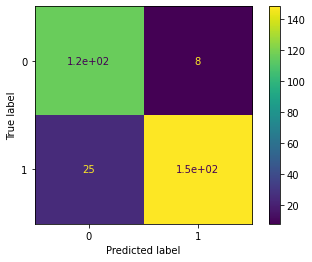

In [22]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)
plot_confusion_matrix(svm, x_test_scaled , y_test)

In [23]:
# Print the imbalanced classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.94      0.88       124
           1       0.95      0.86      0.90       173

    accuracy                           0.89       297
   macro avg       0.89      0.90      0.89       297
weighted avg       0.90      0.89      0.89       297



In [84]:
# Create Decision Tree Model
tree_model = DecisionTreeClassifier(criterion='entropy', splitter='best', max_features='sqrt')

# Train the model
tree_model.fit(x_train_scaled,y_train)

# Evaluate the model
y_pred = tree_model.predict(x_test_scaled)
print(f" Decission Tree model accuracy: {accuracy_score(y_test,y_pred)*100:.2f}%")

 Decission Tree model accuracy: 88.22%


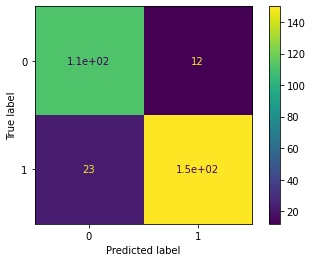

In [92]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)
plot_confusion_matrix(tree_model, x_test_scaled , y_test)

In [93]:
# Print the imbalanced classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86       124
           1       0.93      0.87      0.90       173

    accuracy                           0.88       297
   macro avg       0.88      0.89      0.88       297
weighted avg       0.89      0.88      0.88       297



In [24]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(ml_df.columns.tolist()) - 1
hidden_nodes_layer1 =  5
hidden_nodes_layer2 = 3

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 70        
                                                                 
 dense_1 (Dense)             (None, 3)                 18        
                                                                 
 dense_2 (Dense)             (None, 1)                 4         
                                                                 
Total params: 92
Trainable params: 92
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [88]:
# Define the checkpoint path and filenames
os.makedirs("Checkpoints/",exist_ok=True)
checkpoint_path = "Checkpoints/weights.{epoch:03d}.hdf5"

# Create a callback that saves the model's weights every epoch
cp_callback = ModelCheckpoint(  
    filepath=checkpoint_path,
    verbose=1,
    period = 5,
    save_weights_only=True,
    )

In [89]:
# Train the model
fit_model = nn.fit(x_train_scaled,y_train,epochs=100, callbacks=[cp_callback])

Epoch 1/100
84/84 [==============================] - 0s 2ms/step - loss: 0.3011 - accuracy: 0.8666
Epoch 2/100
84/84 [==============================] - 0s 2ms/step - loss: 0.3012 - accuracy: 0.8670
Epoch 3/100
84/84 [==============================] - 0s 2ms/step - loss: 0.3012 - accuracy: 0.8651
Epoch 4/100
84/84 [==============================] - 0s 2ms/step - loss: 0.3008 - accuracy: 0.8666
Epoch 5/100
73/84 [=========================>....] - ETA: 0s - loss: 0.2957 - accuracy: 0.8711
Epoch 00005: saving model to Checkpoints/weights.005.hdf5
84/84 [==============================] - 0s 2ms/step - loss: 0.3006 - accuracy: 0.8692
Epoch 6/100
84/84 [==============================] - 0s 2ms/step - loss: 0.3007 - accuracy: 0.8670
Epoch 7/100
84/84 [==============================] - 0s 2ms/step - loss: 0.3005 - accuracy: 0.8662
Epoch 8/100
84/84 [==============================] - 0s 2ms/step - loss: 0.3002 - accuracy: 0.8677
Epoch 9/100
84/84 [==============================] - 0s 2ms/step - 

In [90]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(x_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss:.4f}, Accuracy: {model_accuracy:.4}")

10/10 - 0s - loss: 0.2661 - accuracy: 0.8855 - 26ms/epoch - 3ms/step
Loss: 0.2661, Accuracy: 0.8855


In [91]:
# Export our model to HDF5 file
nn.save("student_prediction_model.h5")